# Running the TTGammaProcessor

This cell will copy the test files from their location on eos to your local area. This only needs to be done once!

In [1]:
%load_ext autoreload
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

List of samples to be run on (fileset variable) and a dictionary containing the number of events processed for each sample

In [2]:
fileset = {
    "TTGamma_SingleLept": [
        "root://cmseos.fnal.gov//store/user/cmsdas/2020/long_exercises/TTGamma/TestFiles/TTGamma_1l.root"
    ],
    "TTbarPowheg_Semilept": [
        "root://cmseos.fnal.gov//store/user/cmsdas/2020/long_exercises/TTGamma/TestFiles/TTbar_1l.root"
    ],
    "W4jets": [
        "root://cmseos.fnal.gov//store/user/cmsdas/2020/long_exercises/TTGamma/TestFiles/W4Jets.root"
    ],
    "WGamma_01J_5f": [
        "root://cmseos.fnal.gov//store/user/cmsdas/2020/long_exercises/TTGamma/TestFiles/WGamma.root"
    ],
    "ZGamma_01J_5f_lowMass": [
        "root://cmseos.fnal.gov//store/user/cmsdas/2020/long_exercises/TTGamma/TestFiles/ZGamma.root"
    ],
    "DYjetsM50": [
        "root://cmseos.fnal.gov//store/user/cmsdas/2020/long_exercises/TTGamma/TestFiles/ZJets.root"
    ],
}

Run the TTGammaProcessor on the list of files included in fileset.

You can specify the chunksize and maximum number of chunks to process from each sample (selecting a small number of events and one chunk will force coffea to process only a subset of the events for quicker debugging)

In [3]:
#autoreload forces the kernel to reload the processor to include any new changes
%autoreload 2
from ttgamma import TTGammaProcessor
import awkward as ak

import time
tstart = time.time()

#Run Coffea code using uproot
output = processor.run_uproot_job(
    fileset,
    "Events",
    TTGammaProcessor(isMC=True),
    processor.iterative_executor,
    executor_args={'schema': NanoAODSchema,'workers': 4},
    chunksize=10000,
    maxchunks=1,
)

elapsed = time.time() - tstart
print("Total time: %.1f seconds"%elapsed)
print("Total rate: %.1f events / second"%(output['EventCount'].value/elapsed))

/opt/conda/lib/python3.8/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


Output()

Output()

Total time: 57.3 seconds
Total rate: 1049.5 events / second


In [4]:
output

{'all_photon_pt': <Hist (dataset,pt) instance at 0x7f1d55c04a60>,
 'photon_pt': <Hist (dataset,pt,category,lepFlavor,systematic) instance at 0x7f1d5b508eb0>,
 'photon_eta': <Hist (dataset,eta,category,lepFlavor,systematic) instance at 0x7f1d55c7c190>,
 'photon_chIso': <Hist (dataset,chIso,category,lepFlavor,systematic) instance at 0x7f1d55aa75e0>,
 'photon_lepton_mass_3j0t': <Hist (dataset,mass,category,lepFlavor,systematic) instance at 0x7f1d55aa7bb0>,
 'M3': <Hist (dataset,M3,category,lepFlavor,systematic) instance at 0x7f1d55aa79a0>,
 'EventCount': value_accumulator(int, 60181)}

In [5]:
h = output['photon_pt'].sum("category", "lepFlavor").integrate("systematic", "nominal")

/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


(0.0001, 1000)

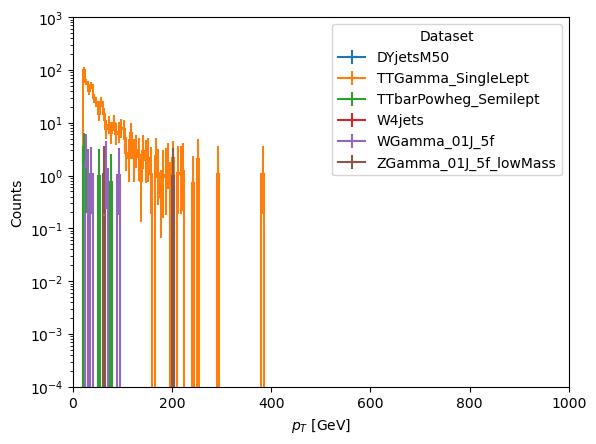

In [6]:
from coffea import hist
import matplotlib.pyplot as plt

hist.plot1d(h, overlay='dataset')
plt.yscale('log')
plt.ylim(1e-4, 1000)

In [7]:
expected = util.load("output_Expected.coffea")

hname = "photon_chIso"
for key in expected[hname].values():
    mine = output[hname].values()[key]
    other = expected[hname].values()[key]
    if (~ak.all(mine == other)):
        print(key, ak.all(mine == other))
print('done!')

done!


# Accessing Arrays Interactively

Below is an example of loading a NanoAOD file interactively. This can be very useful for developing the code, and debugging any issues. Use this area to build your intuition for working with Coffea and awkward arrays!

In [8]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

fname = fileset["TTGamma_SingleLept"][0]
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema).events()

Once you have opened the file, you can explore its contents using the 'fields' syntax

In [9]:
events["Photon", "charge"] = 0
leadingMuon = ak.firsts(events.Muon)
leadingPhoton = ak.firsts(events.Photon)
leadingElectron = ak.firsts(events.Electron)

In [10]:
(leadingMuon + leadingPhoton).mass

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


<Array [271, 32, 32.3, ... None, 94.8, None] type='284276 * ?float32'>

In [23]:
mugammapairs = ak.cartesian({"mu":events.Muon, "gamma":events.Photon})
(mugammapairs.mu + mugammapairs.gamma).mass

<Array [[271], [32, 6.76], ... [94.8, 117], []] type='284276 * var * float32'>

In [11]:
leadingMuon

<MuonArray [Muon, Muon, Muon, ... None, Muon, None] type='284276 * ?muon'>

In [12]:
print(leadingMuon)

[Muon, Muon, Muon, Muon, Muon, Muon, Muon, ... Muon, Muon, None, None, Muon, None]


In [13]:
type(leadingMuon)

coffea.nanoevents.methods.nanoaod.MuonArray

In [14]:
from ttgamma.scalefactors import mu_trig_err

mu_trig_err

2 dimensional histogram with axes:
	1: [0.  0.9 1.2 2.1 2.4]
	2: [ 26.  30.  40.  50.  60. 120. 200. 500.]

In [15]:
mu_trig_err(1.2, 36)

0.0006185738334658688

In [16]:
events.Photon.matched_gen.fields

['eta',
 'mass',
 'phi',
 'pt',
 'genPartIdxMother',
 'pdgId',
 'status',
 'statusFlags',
 'genPartIdxMotherG',
 'distinctParentIdxG',
 'childrenIdxG',
 'distinctChildrenIdxG']

In [17]:
events.GenPart.fields

['eta',
 'mass',
 'phi',
 'pt',
 'genPartIdxMother',
 'pdgId',
 'status',
 'statusFlags',
 'genPartIdxMotherG',
 'distinctParentIdxG',
 'childrenIdxG',
 'distinctChildrenIdxG']

There is also a docstring for each of these variables in NanoAOD, which you can access using '?':

In [18]:
events.Jet.rawFactor?